In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine,reflect=True)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
last_date = session.query(func.max(measurement.date)).scalar()

last_date

'2017-08-23'

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

first_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
first_date = first_date.replace(year=first_date.year - 1)
first_date

datetime.date(2016, 8, 23)

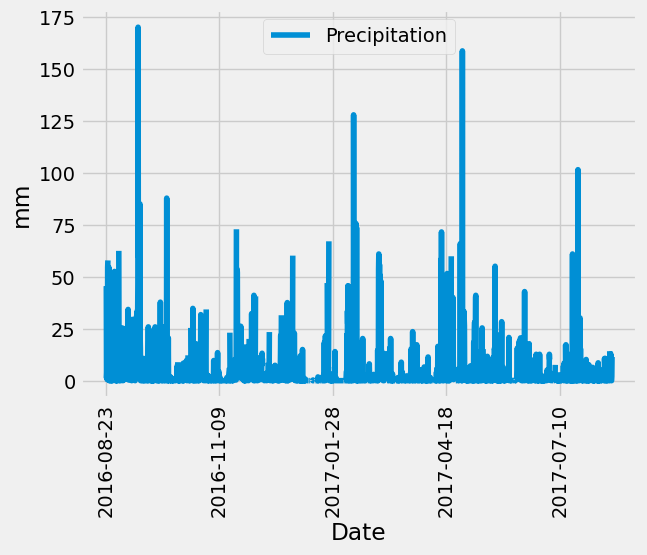

In [44]:
# Perform a query to retrieve the data and precipitation scores

query = (
    session
    .query(measurement.date, measurement.prcp)
    .filter(measurement.date >= first_date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = (
    pd.DataFrame(query, columns=["Date", "Precipitation"])

    # Sort the dataframe by date
    .sort_values(by="Date")
)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(x = 'Date', y = 'Precipitation')
plt.ylabel("mm")
plt.xticks(rotation=90);

In [45]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number of stations in the dataset
session.query(station).count()

9

In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = (
    session
    .query(measurement.station, func.count(measurement.id,))
    .group_by(measurement.station)
    .order_by(func.count(measurement.id).desc())
    .all()
)

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = most_active[0][0]

(
    session
    .query(
        func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)
        )
    .filter(measurement.station == most_active_id)
    .all()
)

[(12.2, 29.4, 22.03582251082252)]

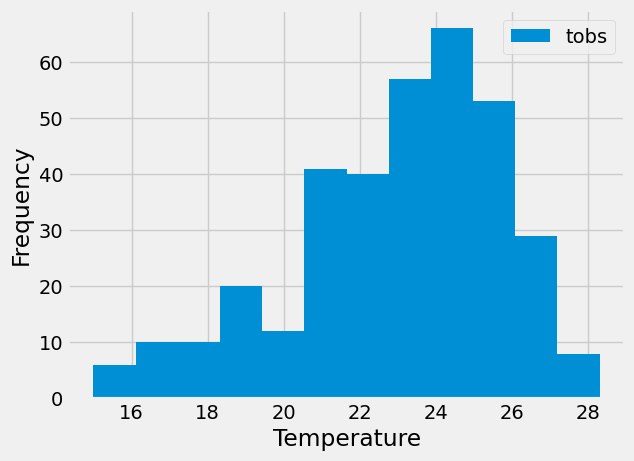

In [62]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
response = (
    session
    .query(measurement.date, measurement.tobs)
    .filter(measurement.date >= first_date)
    .filter(measurement.station == most_active_id)
    .all()
)

temp_df = pd.DataFrame(response, columns=['Date', 'tobs']).set_index('Date')

temp_df['tobs'].plot(kind='hist', bins=12)
plt.xlabel('Temperature')
plt.legend(loc="upper right")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()